<h1 style="color: #FF8C00;">EDA Bivariate Analysis: Diving into Amazon UK Product Insights</h1>

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the Amazon UK product dataset which provides information on product categories, brands, prices, ratings, and more from from Amazon UK.

## Libraries

In [1]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np # For scientific and complex numerical computing in Python
import pandas as pd # For creating and handling tabular data in Python
import matplotlib.pyplot as plt # For data visualization
import seaborn as sns # For high-level data visualization
from scipy import stats

## 00 | Data Extraction and Wrangling

In [3]:
draft = pd.read_csv('amz_uk_price_dataset.csv')

In [4]:
draft.set_index('uid', inplace=True)

In [5]:
df = draft.copy()

## Part 1: Analyzing Best-Seller Trends Across Product Categories
**Objective**: Understand the relationship between product categories and their best-seller status.

1.1 | Crosstab Analysis:

- Create a crosstab between the product category and the Best Seller status.

- Are there categories where being a best-seller is more prevalent?

In [6]:
catxbs = (pd.crosstab(df['category'], df['isBestSeller'])).sort_values(by=True, ascending=False)

In [7]:
catxbs['proportion'] = (catxbs[True] / (catxbs[True] + catxbs[False])) * 100

In [8]:
catxbs.sort_values(by='proportion', ascending=False).round(2).head(10)

isBestSeller,False,True,proportion
category,,,
Grocery,9008,556,5.81
Smart Home Security & Lighting,98,6,5.77
Health & Personal Care,9017,552,5.77
Mobile Phone Accessories,248,11,4.25
Power & Hand Tools,8353,306,3.53
"Billiard, Snooker & Pool",241,8,3.21
Pet Supplies,9152,285,3.02
Home Brewing & Wine Making,239,7,2.85
Wind Instruments,243,7,2.80


The top 10 categories with the highest proportions of best-sellers are as follows: "Grocery" leads with the highest proportion at 5.81%, followed closely by "Smart Home Security & Lighting" and "Health & Personal Care," both at approximately 5.77%. Other notable categories include "Mobile Phone Accessories," "Power & Hand Tools," and "Billiard, Snooker & Pool," all with proportions above 3%. These categories have significantly higher proportions of best-sellers compared to others, suggesting that being a best-seller is more prevalent within these product categories.

1.2 | Statistical Tests:

- Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
- Compute Cramér's V to understand the strength of association between best-seller status and category.

In [15]:
catxbs = catxbs.drop(columns='proportion')

In [16]:
chi2, p_value, dof, expected = stats.chi2_contingency(catxbs)

In [19]:
chi2.round(3)

36540.203

The Chi-square value of 36,540.203 shows how much the actual number of best-sellers in each product category differs from what we'd expect if best-seller status were random across categories. A large value like this means there’s a strong relationship between product category and being a best-seller — in other words, some categories are much more likely to have best-sellers than others.

In [20]:
p_value

0.0

A p-value of 0.0 means that the probability of observing the results you got (or more extreme results) due to random chance is extremely low. In practical terms, it suggests that there is a very strong relationship between the product category and best-seller status. The p-value is so small that it is essentially telling us that the likelihood of this relationship happening by chance is negligible.

---

To compute Cramér's V, which measures the strength of association between two categorical variables, the following formula is applicable:

$$
V = \sqrt{\frac{\chi^2}{n \cdot \min(k - 1, r - 1)}}
$$

Where:

- **χ²** is the Chi-square statistic (which we already have).
- **n** is the total number of observations.
- **k** is the number of categories in the first variable (here, the number of unique categories in `category`).
- **r** is the number of categories in the second variable (the number of unique categories in `isBestSeller`).

In [39]:
print(f'Chi2 is: {(chi2).round(3)}.')

Chi2 is: 36540.203.


In [30]:
n = catxbs.sum().sum() # summing up everything together
print(f'Total number of observations is: {n}.')

Total number of observations is: 2443651.


In [33]:
k = catxbs.shape[1] # Number of columns
print(f'There are {k} categories.')

There are 2 categories.


In [36]:
r = catxbs.shape[0] # Number of rows, would also work with len(ct)
print(f'There are {r} rows.')

There are 296 rows.


In [40]:
cramer = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
cramer.round(2)

0.12

- The **p-value (0.0)** indicates that **the relationship between category and isBestSeller is statistically significant** (there is a strong enough relationship to be confident it's not random).
- However, the **Cramér's V value (0.12)** indicates that, while statistically significant, the strength of **the relationship is only weak to moderate**. So, there's a statistically significant relationship, but it's not a very strong one.

1.3 | Visualizations

- Visualize the relationship between product categories and the best-seller status using a bar chart.

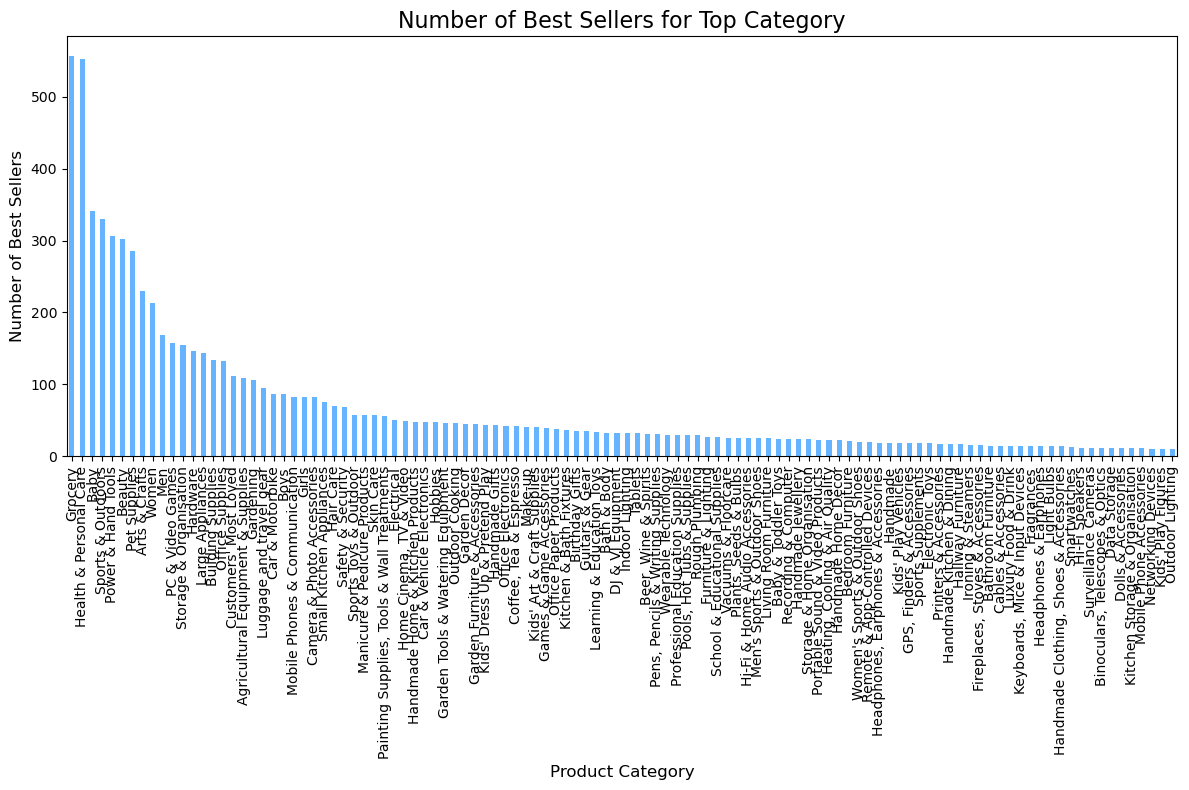

In [58]:
# Filter out categories with no Best Sellers (True value starting at 10)
catxbs_filtered = catxbs[catxbs[True] > 9]

# Plotting the number of Best Sellers (True) per category
catxbs_filtered[True].plot(kind='bar', figsize=(12, 8), color='#66b3ff')

# Adding labels and title for better readability
plt.title('Number of Best Sellers for Top Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Number of Best Sellers', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()  # Ensures everything fits well

# Show the plot
plt.show()

---

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands
**Objective**: Investigate how different product categories influence product prices.

2.00 | Price Data Cleaning

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. This method provides a simple, effective way to clean the data without making subjective decisions about what constitutes an outlier. The next steps will be done with a cleaner dataframe.

In [82]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
print(f'A quarter of the products costs less than £{Q1},')
print(f'while the high-end quarter costs more than £{Q3}.')

A quarter of the products costs less than £9.99,
while the high-end quarter costs more than £45.99.


In [70]:
IQR = Q3 - Q1

In [76]:
lr = Q1 - 1.5 * IQR
ur = Q3 + 1.5 * IQR

In [63]:
df2 = df[(df['price'] >= lr) & (df['price'] <= ur)]

2.1 | Violin Plots

- Filter out the top 20 categories based on count for better visualization.

In [163]:
top20 = df2['category'].value_counts().nlargest(20).index

In [164]:
df3 = df2[df2['category'].isin(top20)]

- Use a violin plot to visualize the distribution of price across different product categories.

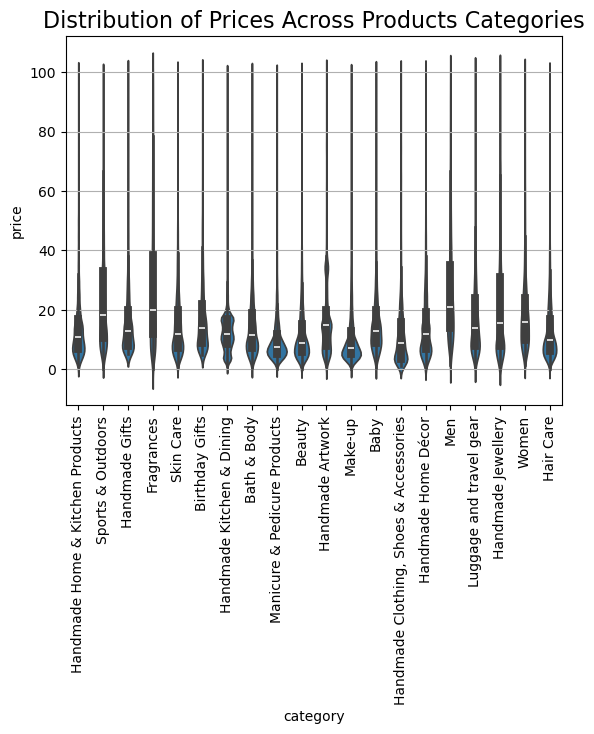

In [100]:
sns.violinplot(x='category',
               y='price',
               data=df3)
plt.grid(True, axis='y')
plt.title('Distribution of Prices Across Products Categories', fontsize=16)
plt.xticks(rotation=90)
plt.show()

Across all top categories, the majority of prices are in range of 30 pounds. With a few higher prices for other categories that do not normally exceed 40 pounds.

- Which product category tends to have the highest median price? Don't filter here by top categories.

In [111]:
df.groupby('category')['price'].median().reset_index().sort_values(by='price', ascending=False)[:1].round(2)

,category,price
165,Laptops,1042.72


2.2 | Bar Charts
- Create a bar chart comparing the average price of products for the top 10 product categories (based on count).

In [161]:
top10 = df2['category'].value_counts().nlargest(10).index

In [162]:
df4 = df2[df2['category'].isin(top10)].groupby('category')['price'].mean().sort_values(ascending=False).reset_index()

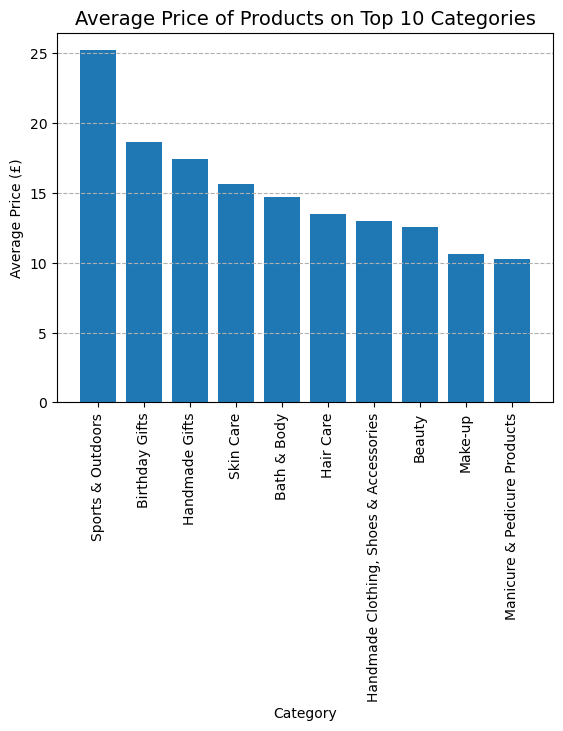

In [156]:
plt.bar(df4.category, df4.price)
plt.title('Average Price of Products on Top 10 Categories', fontsize=14)
plt.ylabel('Average Price (£)')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--')
plt.show()

Sports & Outdoors leads not only as top category by count but also by average price as well, with the average product costing around 25 pounds.

- Which product category commands the highest average price? Don't filter here by top categories.

In [192]:
df.groupby('category')['price'].mean().reset_index()[:1].round(2) # If we don't consider outliers

,category,price
0,3D Printers,1018.04


In [159]:
df2.groupby('category')['price'].mean().reset_index()[:1].round(2) # If we consider outliers

,category,price
0,3D Printers,55.74


2.3 | Box Plots
- Visualize the distribution of product ratings based on their category using side-by-side box plots (in the Top 10 categories by count).

In [171]:
df5 = df2[df2['category'].isin(top10)]

I know the exercise doesn't explicitly requires cleaning ratings data, but it bothers me how radically different of a conclusion we can draw without filtering out products with no reviews, since they are labeled as 0 stars. I, therefore, chose to plot only the ratings of products that were actually reviewed.

In [178]:
df5 = df5[df5['reviews'] > 1]

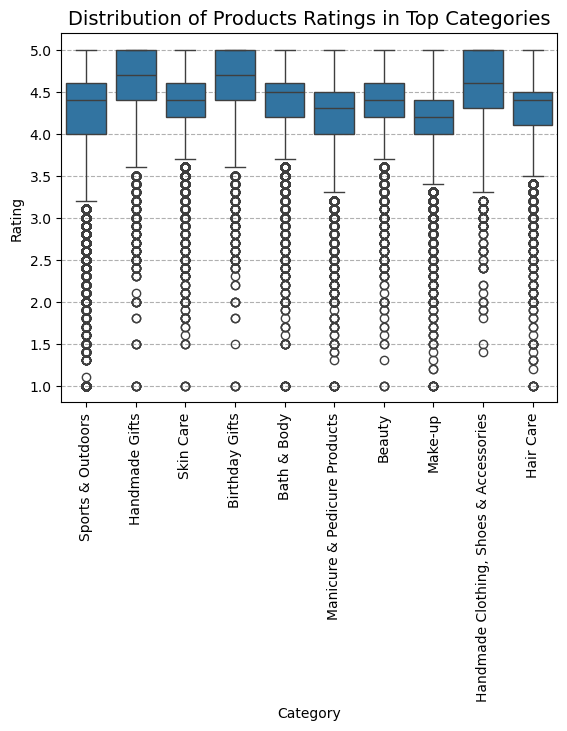

In [183]:
sns.boxplot(x='category', y='stars', data=df5)
plt.title('Distribution of Products Ratings in Top Categories', fontsize=14)
plt.xlabel('Category')
plt.ylabel('Rating')
plt.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=90)
plt.show()

- Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [198]:
(df2[df2['reviews'] > 1]).groupby('category')['stars'].median().reset_index()[:1].round(1) # If we consider outliers

,category,stars
0,3D Printers,4.3


In [196]:
df2.groupby('category')['stars'].median().reset_index()[:1].round(1) # If we don't consider outliers

,category,stars
0,3D Printers,4.1


The difference between considering or not outliers here is not so big because we are working with the median instead of the mean, which is much less sensitive to them.

---

## Part 3: Investigating the Interplay Between Product Prices and Ratings
**Objective**: Analyze how product ratings (stars) correlate with product prices.

3.1 | Correlation Coefficient
- Calculate the correlation coefficient between price and stars.

In [203]:
df2['price'].corr(df2['stars']).round(3) # If we don't consider ratings outliers

-0.078

In [204]:
df5['price'].corr(df5['stars']).round(3) # If we consider ratings outliers

0.068

Given that the correlation coefficient is so close to zero in both situations, it's likely that **there is no significant correlation between price and rating**. These two variables, therefore, have no meaningful linear relationship.

3.2 | Visualizations
- Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?

<Axes: xlabel='price', ylabel='stars'>

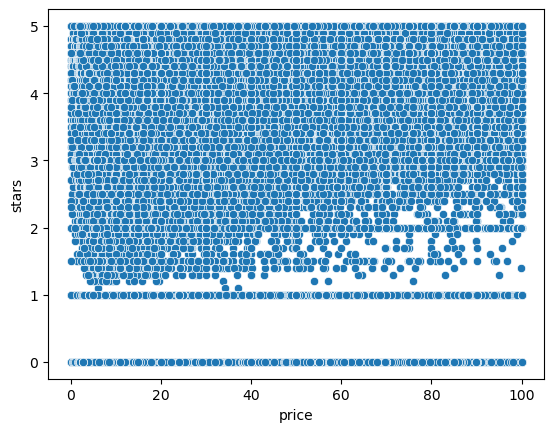

In [207]:
sns.scatterplot(x='price', y='stars', data=df2)

A scatter plot that shows dots scattered all over the map with no visible trend like this supports the conclusion that the variables have no linear relationship between them.

- Use a correlation heatmap to visualize correlations between all numerical variables.

In [227]:
df6 = df5.set_index('category') # Just for eventual human reference, without affecting numerical analysis
# Plus it's easy because the original dataset is already grouped by category

In [228]:
df6 = df6.select_dtypes(include=['number'])

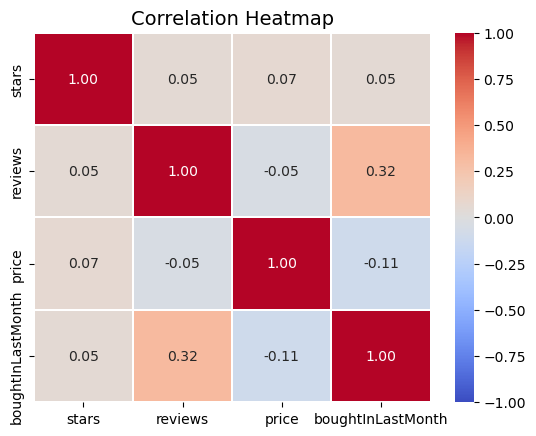

In [238]:
sns.heatmap((df6.corr()), annot=True, cmap='coolwarm', vmin=-1, linewidths=0.25, fmt='.2f')
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

- Examine if product prices typically follow a normal distribution using a QQ plot.

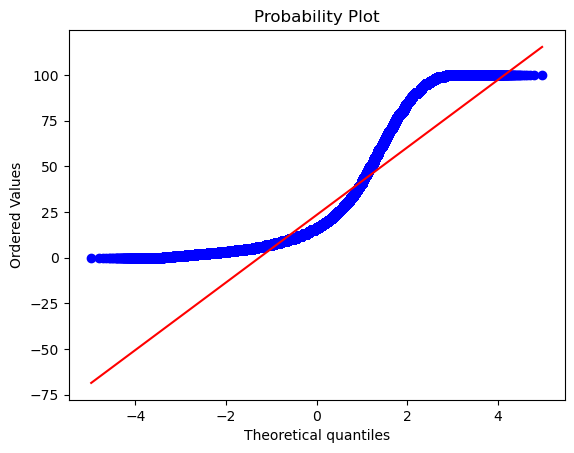

In [242]:
stats.probplot(df2['price'], dist='norm', plot=plt)
plt.show()